In [21]:
## Project 3: Tracking User Engagement with SQL, Excel, and Python Project

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Make the plots look a bit nicer
plt.style.use("default")
sns.set_theme()

# So we can see more columns/rows when printing tables
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)


In [23]:
# Load CSVs (expects them in the same folder as this notebook)
df_2021_paid_0 = pd.read_csv(
    "minutes_watched_2021_paid_0.csv",
    header=None,
    names=["student_id", "minutes_watched", "paid_in_q2"]
)

df_2022_paid_0 = pd.read_csv(
    "minutes_watched_2022_paid_0.csv",
    header=None,
    names=["student_id", "minutes_watched", "paid_in_q2"]
)

df_2021_paid_1 = pd.read_csv(
    "minutes_watched_2021_paid_1.csv",
    header=None,
    names=["student_id", "minutes_watched", "paid_in_q2"]
)

df_2022_paid_1 = pd.read_csv(
    "minutes_watched_2022_paid_1.csv",
    header=None,
    names=["student_id", "minutes_watched", "paid_in_q2"]
)

# Put everything into a dictionary for easy iteration
dataframes = {
    "2021_Free": df_2021_paid_0,
    "2022_Free": df_2022_paid_0,
    "2021_Paid": df_2021_paid_1,
    "2022_Paid": df_2022_paid_1,
}

print("--- Initial DataFrames Loaded ---")
for name, df in dataframes.items():
    print(f"\n{name} → shape = {df.shape}")
    print(df.head())


--- Initial DataFrames Loaded ---

2021_Free → shape = (13408, 3)
   student_id  minutes_watched  paid_in_q2
0         767             0.05           0
1         902            34.62           0
2        1067             0.27           0
3        1151           328.58           0
4        1221           227.30           0

2022_Free → shape = (12354, 3)
   student_id  minutes_watched  paid_in_q2
0         389             0.15           0
1         520            91.18           0
2         523          1322.25           0
3         594             3.73           0
4         603             8.18           0

2021_Paid → shape = (2432, 3)
   student_id  minutes_watched  paid_in_q2
0           6           148.12           1
1         389             0.15           1
2         516            46.27           1
3         520            91.18           1
4         523          1322.25           1

2022_Paid → shape = (3486, 3)
   student_id  minutes_watched  paid_in_q2
0           6          

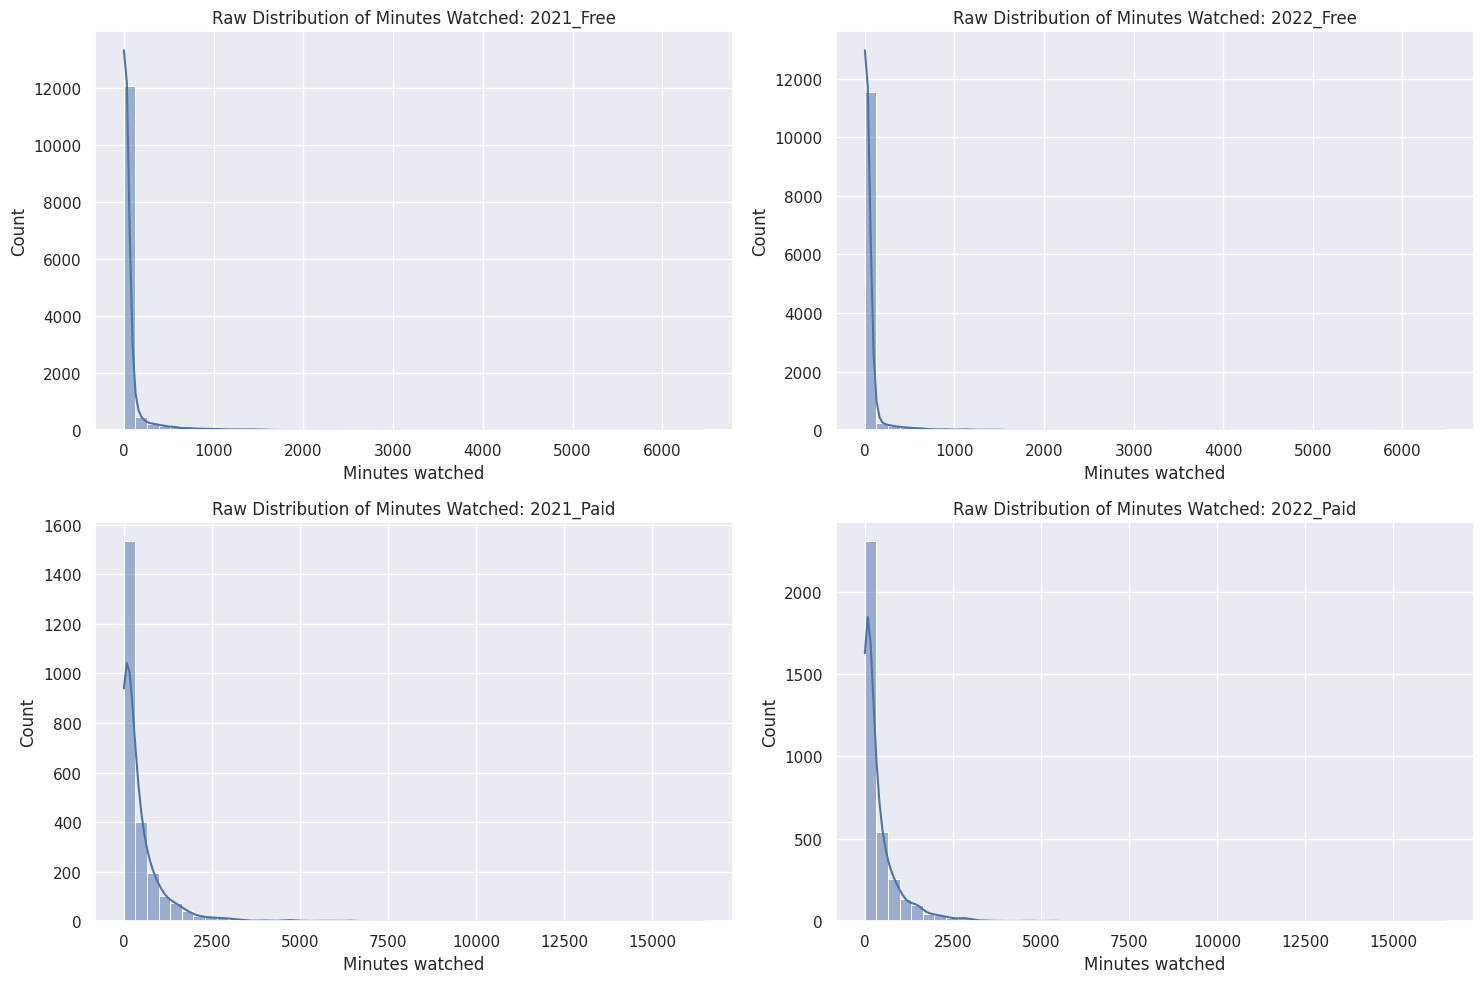

In [24]:
plt.figure(figsize=(15, 10))

for i, (name, df) in enumerate(dataframes.items(), start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df["minutes_watched"], kde=True, bins=50)
    plt.title(f"Raw Distribution of Minutes Watched: {name}")
    plt.xlabel("Minutes watched")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [25]:
filtered_dataframes = {}

print("\n--- Outlier Removal (Using 99th Percentile) ---")

for name, df in dataframes.items():
    threshold_99 = df["minutes_watched"].quantile(0.99)

    print(f"\n{name}:")
    print(f"- 99th percentile threshold = {threshold_99:.2f} minutes")

    df_filtered = df[df["minutes_watched"] < threshold_99].copy()
    filtered_dataframes[name] = df_filtered

    original_n = len(df)
    filtered_n = len(df_filtered)
    removed_pct = (original_n - filtered_n) / original_n * 100

    print(f"- Original rows: {original_n}")
    print(f"- Filtered rows: {filtered_n}  ({removed_pct:.2f}% removed)")




--- Outlier Removal (Using 99th Percentile) ---

2021_Free:
- 99th percentile threshold = 1316.01 minutes
- Original rows: 13408
- Filtered rows: 13273  (1.01% removed)

2022_Free:
- 99th percentile threshold = 1076.56 minutes
- Original rows: 12354
- Filtered rows: 12230  (1.00% removed)

2021_Paid:
- 99th percentile threshold = 3677.69 minutes
- Original rows: 2432
- Filtered rows: 2407  (1.03% removed)

2022_Paid:
- 99th percentile threshold = 2856.02 minutes
- Original rows: 3486
- Filtered rows: 3451  (1.00% removed)


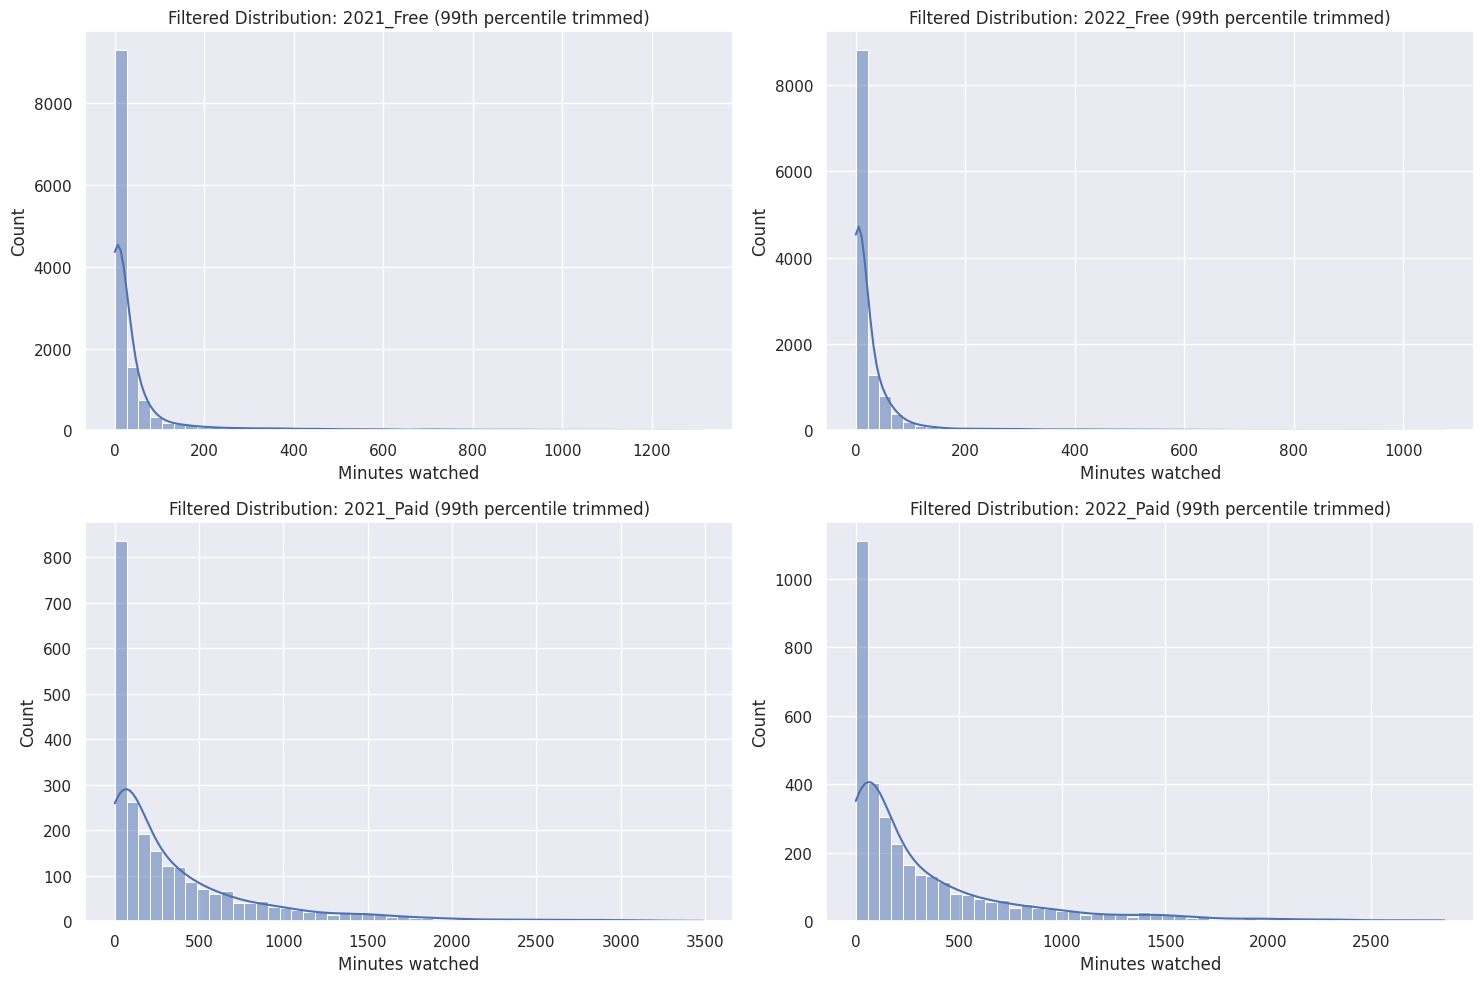

In [26]:
plt.figure(figsize=(15, 10))

for i, (name, df_filtered) in enumerate(filtered_dataframes.items(), start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filtered["minutes_watched"], kde=True, bins=50)
    plt.title(f"Filtered Distribution: {name} (99th percentile trimmed)")
    plt.xlabel("Minutes watched")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [27]:
df_2021_free_clean  = filtered_dataframes["2021_Free"]
df_2022_free_clean  = filtered_dataframes["2022_Free"]
df_2021_paid_clean  = filtered_dataframes["2021_Paid"]
df_2022_paid_clean  = filtered_dataframes["2022_Paid"]

print("Cleaned data ready in memory (no CSVs written).")
for name, df in filtered_dataframes.items():
    print(f"{name}: {df.shape[0]} rows after outlier removal")

Cleaned data ready in memory (no CSVs written).
2021_Free: 13273 rows after outlier removal
2022_Free: 12230 rows after outlier removal
2021_Paid: 2407 rows after outlier removal
2022_Paid: 3451 rows after outlier removal


In [28]:
print("\n" + "=" * 60)
print("I. MEAN & MEDIAN (Filtered Data)")
print("=" * 60)

mean_median_data = {}

for name, df in filtered_dataframes.items():
    mean_val = df["minutes_watched"].mean()
    median_val = df["minutes_watched"].median()
    mean_median_data[name] = {"Mean": mean_val, "Median": median_val}

mean_median_df = pd.DataFrame(mean_median_data).T
print(mean_median_df.to_markdown(floatfmt=".2f"))

# --- Mean vs Median: How skewed are the distributions? ---
print("\n--- Mean vs Median (Skewness intuition) ---")
for name, row in mean_median_df.iterrows():
    mean_val = row["Mean"]
    median_val = row["Median"]

    if median_val != 0:
        diff_pct = (mean_val - median_val) / median_val * 100
    else:
        diff_pct = np.nan

    if mean_val > median_val:
        skew_text = "likely **right-skewed** (few heavy users pulling the mean up)"
    elif mean_val < median_val:
        skew_text = "likely **left-skewed**"
    else:
        skew_text = "probably very **symmetric**"

    print(
        f"- {name}: mean = {mean_val:.2f}, median = {median_val:.2f}, "
        f"mean–median diff ≈ {diff_pct:.2f}% → {skew_text}."
    )

# --- Year-on-year change (2022 vs 2021) for Free & Paid ---
print("\n--- Year-on-Year Change: 2022 vs 2021 ---")

for group_type in ["Free", "Paid"]:
    mean_21 = mean_median_df.loc[f"2021_{group_type}", "Mean"]
    mean_22 = mean_median_df.loc[f"2022_{group_type}", "Mean"]
    change_pct = (mean_22 - mean_21) / mean_21 * 100

    print(
        f"- {group_type} learners: mean minutes watched changed by "
        f"{change_pct:.2f}% from 2021 → 2022."
    )



I. MEAN & MEDIAN (Filtered Data)
|           |   Mean |   Median |
|:----------|-------:|---------:|
| 2021_Free |  53.26 |     6.50 |
| 2022_Free |  35.97 |     5.32 |
| 2021_Paid | 392.54 |   175.87 |
| 2022_Paid | 353.60 |   154.95 |

--- Mean vs Median (Skewness intuition) ---
- 2021_Free: mean = 53.26, median = 6.50, mean–median diff ≈ 719.44% → likely **right-skewed** (few heavy users pulling the mean up).
- 2022_Free: mean = 35.97, median = 5.32, mean–median diff ≈ 576.18% → likely **right-skewed** (few heavy users pulling the mean up).
- 2021_Paid: mean = 392.54, median = 175.87, mean–median diff ≈ 123.20% → likely **right-skewed** (few heavy users pulling the mean up).
- 2022_Paid: mean = 353.60, median = 154.95, mean–median diff ≈ 128.20% → likely **right-skewed** (few heavy users pulling the mean up).

--- Year-on-Year Change: 2022 vs 2021 ---
- Free learners: mean minutes watched changed by -32.46% from 2021 → 2022.
- Paid learners: mean minutes watched changed by -9.92% f


II. 95% CONFIDENCE INTERVALS
|           |   Count (n) |   Mean |   Lower Bound |   Upper Bound |
|:----------|------------:|-------:|--------------:|--------------:|
| 2021_Free |    13273.00 |  53.26 |         50.77 |         55.75 |
| 2022_Free |    12230.00 |  35.97 |         34.13 |         37.81 |
| 2021_Paid |     2407.00 | 392.54 |        370.71 |        414.38 |
| 2022_Paid |     3451.00 | 353.60 |        337.29 |        369.92 |

--- Comparing 2022 means against 2021 CIs ---

Free learners:
- 2021 CI = (50.77, 55.75)
- 2022 mean = 35.97
  → 2022 is **below** the 2021 CI → suggests a statistically significant **decrease**.

Paid learners:
- 2021 CI = (370.71, 414.38)
- 2022 mean = 353.60
  → 2022 is **below** the 2021 CI → suggests a statistically significant **decrease**.


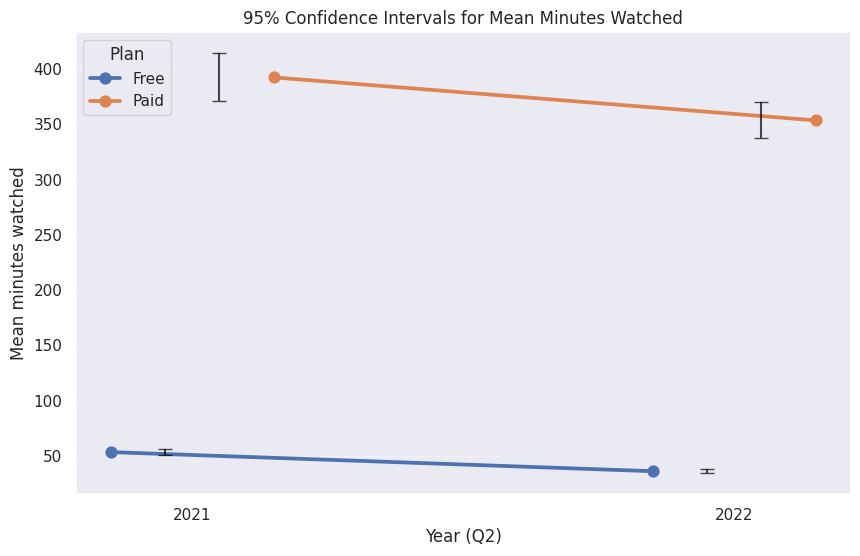

In [29]:
print("\n" + "=" * 60)
print("II. 95% CONFIDENCE INTERVALS")
print("=" * 60)

Z_CRITICAL = stats.norm.ppf(0.975)  # ~1.96

ci_results = {}

for name, df in filtered_dataframes.items():
    data = df["minutes_watched"]
    n = len(data)
    mean_val = data.mean()
    std_dev = data.std(ddof=1)  # sample standard deviation

    std_error = std_dev / np.sqrt(n)
    margin = Z_CRITICAL * std_error
    lower = mean_val - margin
    upper = mean_val + margin

    ci_results[name] = {
        "Count (n)": n,
        "Mean": mean_val,
        "Std Dev": std_dev,
        "Std Error": std_error,
        "Margin of Error": margin,
        "Lower Bound": lower,
        "Upper Bound": upper,
    }

ci_df = pd.DataFrame(ci_results).T
print(ci_df[["Count (n)", "Mean", "Lower Bound", "Upper Bound"]].to_markdown(floatfmt=".2f"))

# Interpret whether 2022 mean lies outside 2021 CI
print("\n--- Comparing 2022 means against 2021 CIs ---")
for group_type in ["Free", "Paid"]:
    lower_21 = ci_df.loc[f"2021_{group_type}", "Lower Bound"]
    upper_21 = ci_df.loc[f"2021_{group_type}", "Upper Bound"]
    mean_22 = ci_df.loc[f"2022_{group_type}", "Mean"]

    print(f"\n{group_type} learners:")
    print(f"- 2021 CI = ({lower_21:.2f}, {upper_21:.2f})")
    print(f"- 2022 mean = {mean_22:.2f}")

    if mean_22 > upper_21:
        print("  → 2022 is **above** the 2021 CI → suggests a statistically significant **increase**.")
    elif mean_22 < lower_21:
        print("  → 2022 is **below** the 2021 CI → suggests a statistically significant **decrease**.")
    else:
        print("  → 2022 lies **inside** the 2021 CI → change might **not** be statistically significant.")

# Prepare data for plotting CIs
ci_df_plot = ci_df.copy()
ci_df_plot["Year"] = [idx.split("_")[0] for idx in ci_df_plot.index]
ci_df_plot["Plan"] = [idx.split("_")[1] for idx in ci_df_plot.index]
ci_df_plot["Error"] = ci_df_plot["Upper Bound"] - ci_df_plot["Mean"]

# Simple CI point plot
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=ci_df_plot,
    x="Year",
    y="Mean",
    hue="Plan",
    dodge=0.3,
    errorbar=None,
)

# Manually draw error bars
for i, row in ci_df_plot.iterrows():
    year_index = 0 if row["Year"] == "2021" else 1
    x_pos = year_index + (-0.05 if row["Plan"] == "Free" else 0.05)
    plt.errorbar(
        x=x_pos,
        y=row["Mean"],
        yerr=row["Error"],
        fmt="none",
        capsize=5,
        ecolor="black",
        alpha=0.7,
    )

plt.title("95% Confidence Intervals for Mean Minutes Watched")
plt.ylabel("Mean minutes watched")
plt.xlabel("Year (Q2)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [30]:
print("\n" + "=" * 60)
print("III. HYPOTHESIS TESTING (One-sided t-tests)")
print("=" * 60)

ALPHA = 0.05

# --- Free plan: assume equal variances ---
print("\n--- Free learners (Equal variances assumed) ---")

data_free_21 = filtered_dataframes["2021_Free"]["minutes_watched"]
data_free_22 = filtered_dataframes["2022_Free"]["minutes_watched"]

t_free, p_free = stats.ttest_ind(
    data_free_22,  # put 2022 first
    data_free_21,
    equal_var=True,
    alternative="greater",  # H_a: mean_2022 > mean_2021
)

print(f"2021: n={len(data_free_21):,}, mean={data_free_21.mean():.2f}")
print(f"2022: n={len(data_free_22):,}, mean={data_free_22.mean():.2f}")
print(f"t-statistic = {t_free:.4f}")
print(f"one-sided p-value = {p_free:.4f}")

if p_free < ALPHA:
    print("→ Reject H₀: **Free learners show a statistically significant increase in engagement in 2022.**")
else:
    print("→ Fail to reject H₀: No statistically significant evidence of higher engagement for free learners in 2022.")


# --- Paid plan: Welch's t-test (unequal variances) ---
print("\n--- Paid learners (Welch's t-test, unequal variances) ---")

data_paid_21 = filtered_dataframes["2021_Paid"]["minutes_watched"]
data_paid_22 = filtered_dataframes["2022_Paid"]["minutes_watched"]

t_paid, p_paid = stats.ttest_ind(
    data_paid_22,
    data_paid_21,
    equal_var=False,
    alternative="greater",
)

print(f"2021: n={len(data_paid_21):,}, mean={data_paid_21.mean():.2f}")
print(f"2022: n={len(data_paid_22):,}, mean={data_paid_22.mean():.2f}")
print(f"t-statistic = {t_paid:.4f}")
print(f"one-sided p-value = {p_paid:.4f}")

if p_paid < ALPHA:
    print("→ Reject H₀: **Paid learners show a statistically significant increase in engagement in 2022.**")
else:
    print("→ Fail to reject H₀: No statistically significant evidence of higher engagement for paid learners in 2022.")




III. HYPOTHESIS TESTING (One-sided t-tests)

--- Free learners (Equal variances assumed) ---
2021: n=13,273, mean=53.26
2022: n=12,230, mean=35.97
t-statistic = -10.7919
one-sided p-value = 1.0000
→ Fail to reject H₀: No statistically significant evidence of higher engagement for free learners in 2022.

--- Paid learners (Welch's t-test, unequal variances) ---
2021: n=2,407, mean=392.54
2022: n=3,451, mean=353.60
t-statistic = -2.8001
one-sided p-value = 0.9974
→ Fail to reject H₀: No statistically significant evidence of higher engagement for paid learners in 2022.


In [31]:
print("\n" + "=" * 60)
print("IV. TYPE I vs TYPE II ERRORS (Business View)")
print("=" * 60)

print("\nType I Error (False Positive):")
print("- We conclude engagement **increased** (reject H₀) when in reality it did **not**.")
print("- Business impact:")
print("  * Company keeps investing in these features.")
print("  * But those features are not actually effective.")
print("  * Cost = wasted engineering / marketing resources, but at least we still have a working product.")

print("\nType II Error (False Negative):")
print("- We conclude engagement did **not** increase (fail to reject H₀) when in reality it **did**.")
print("- Business impact:")
print("  * Company might de-prioritise or shut down features that are actually helping.")
print("  * We miss out on higher revenue, retention, and competitive advantage.")
print("  * Cost = long-term opportunity loss, which can be much larger than the wasted spend from a Type I error.")

print("\nIn this scenario, a **Type II error** is often more painful in the long run,")
print("because it means we kill or ignore genuinely successful features.")



IV. TYPE I vs TYPE II ERRORS (Business View)

Type I Error (False Positive):
- We conclude engagement **increased** (reject H₀) when in reality it did **not**.
- Business impact:
  * Company keeps investing in these features.
  * But those features are not actually effective.
  * Cost = wasted engineering / marketing resources, but at least we still have a working product.

Type II Error (False Negative):
- We conclude engagement did **not** increase (fail to reject H₀) when in reality it **did**.
- Business impact:
  * Company might de-prioritise or shut down features that are actually helping.
  * We miss out on higher revenue, retention, and competitive advantage.
  * Cost = long-term opportunity loss, which can be much larger than the wasted spend from a Type I error.

In this scenario, a **Type II error** is often more painful in the long run,
because it means we kill or ignore genuinely successful features.


In [32]:
try:
    # Replace the file name / columns here if necessary
    cert_df = pd.read_csv("minutes_and_certificates.csv")

    print("\n--- Loaded minutes_and_certificates.csv ---")
    print(cert_df.head())

    # Basic sanity check
    required_cols = {"minutes_watched", "certificates_issued"}
    if not required_cols.issubset(cert_df.columns):
        raise ValueError(f"CSV must contain columns: {required_cols}")

    # Pearson correlation
    r = cert_df["minutes_watched"].corr(cert_df["certificates_issued"])

    print(f"\nPearson correlation r(minutes_watched, certificates_issued) = {r:.4f}")

    # Interpretation
    if r > 0.7:
        strength = "strong positive"
    elif r > 0.3:
        strength = "moderate positive"
    elif r > 0.0:
        strength = "weak positive"
    elif r > -0.3:
        strength = "weak negative"
    elif r > -0.7:
        strength = "moderate negative"
    else:
        strength = "strong negative"

    print("\nInterpretation:")
    print(f"- Strength: {strength} linear relationship.")
    if r >= 0:
        print("- Direction: As minutes watched increase, certificates issued tend to increase as well.")
    else:
        print("- Direction: As minutes watched increase, certificates issued tend to decrease.")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=cert_df,
        x="minutes_watched",
        y="certificates_issued",
        alpha=0.6,
    )
    plt.title(f"Minutes Watched vs Certificates Issued (r = {r:.2f})")
    plt.xlabel("Minutes watched")
    plt.ylabel("Certificates issued")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

except FileNotFoundError:
    print("\n[Optional step skipped] 'minutes_and_certificates.csv' not found in the current folder.")
    print("→ If you want to run the correlation analysis, place the CSV here and re-run this cell.")
except ValueError as e:
    print("\n[Optional step skipped] Problem with the certificates CSV:")
    print(e)


--- Loaded minutes_and_certificates.csv ---
   4640   1   586.80
0  5836   3  1903.12
1   801  13  6066.00
2  2022   1   115.37
3  6278   2  2181.32
4  2731   2   508.50

[Optional step skipped] Problem with the certificates CSV:
CSV must contain columns: {'minutes_watched', 'certificates_issued'}
